# Overview of the Methodology:
The paper proposes a novel framework for zero-shot semantic segmentation (ZSS), which focuses on addressing the adverse effects caused by noisy and outlying training samples of the seen classes. It leverages Bayesian uncertainty estimation to discriminate between representative and noisy samples during training.

# Key components of their approach include:

Pixel-level Learning with Stochastic Binary Cross-Entropy: For pixel-wise prediction.
Image-level Learning with Bayesian Regression: For overall segmentation quality assessment.
Implementation Steps:
1. Preprocessing:
Dataset Preparation: The framework likely requires datasets with images and their corresponding semantic segmentation maps.
Semantic Embeddings: You'll need to generate semantic embeddings for the classes. This could be done using models like word2vec or GloVe.
2. Model Architecture:
Base Network for Feature Extraction: A deep convolutional neural network (e.g., ResNet, VGG) to extract features from images.
Semantic Embedding Integration: Integrate semantic embeddings into the network to create visual-semantic mappings.
Output Layers: Two output branches are required, one for pixel-wise prediction and another for the overall segmentation quality.
3. Uncertainty Estimation:
Stochastic Binary Cross-Entropy: For pixel-level learning, modify the traditional BCE loss to incorporate uncertainty.
Bayesian Regression for Image-level Learning: Use a Laplacian distribution parameterized by the network's outputs to estimate the uncertainty.
4. Training:
Loss Functions: Implement the uncertainty-aware loss functions for pixel-level and image-level learning.
Optimization: Use an optimizer like SGD or Adam to train the model. Regularize the training to avoid overfitting, especially considering the zero-shot learning context.
5. Visualization:
Intermediate Outputs: Visualize the outputs of the network to understand the semantic segmentation results.
Uncertainty Maps: Visualize the uncertainty estimations to see which areas of the image the model is less certain about.
6. Evaluation:
Zero-Shot Learning Evaluation: Test the model on unseen classes to evaluate its zero-shot learning capabilities.
Metrics: Use metrics like mean Intersection-over-Union (mIoU) to assess the segmentation performance.

# Here's a summary of what each part of your code is doing:

GaussianLaplacianLogic Block: This block computes Gaussian and Laplacian parameters from the inputs and combines them. It's a custom logic layer for your model.

ZeroShotSegmentationNet Model: This is your main segmentation model. It includes:

A backbone model for feature extraction (backbone).
A dense layer to process semantic embeddings (embedding_fc).
A convolutional layer to classify combined features (classifier).
A custom Gaussian-Laplacian logic layer (custom_gaussian_laplacian_logic).
A Dice loss layer (dice_layer).
DiceLayer Block: This block calculates the Dice loss, which is commonly used in segmentation tasks.

ADE20KZeroShot Dataset Class: This class is for loading the ADE20K dataset and includes:

An embedding layer to convert class labels to embeddings (embedding_layer).
A method to map class labels to indices (_create_label_index_mapping).
A custom __getitem__ method to return image, embeddings, and mask for each dataset item.

# Challenges and Considerations:

- Zero-Shot Learning Complexity: The concept of zero-shot learning, especially in semantic segmentation, is challenging due to the absence of training examples for some classes.
- Uncertainty Estimation: Implementing uncertainty estimation within a deep learning model can be complex and requires a solid understanding of Bayesian methods.
- Computational Resources: Training such models with large datasets and complex architectures may require significant computational resources.

# Final Thoughts:

Implementing this paper's methodology requires advanced skills in deep learning, particularly in semantic segmentation and Bayesian methods. The project would likely be iterative, requiring adjustments to the model architecture and training process based on initial results and evaluations.


# Resources and modules used:

###### We used GluonCV and their tutorials for the preprocessing and building models

# Install theses dependencies

In [ ]:
# pip install gluoncv[full] mxnet-cu101 --upgrade
# conda install pytorch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0 pytorch-cuda=11.7 -c pytorch -c nvidia
# pip install gensim
#  numpy-1.16.6

# Importing libraries

In [1]:
import ade20k
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn

import gluoncv
from gluoncv.utils import download, makedirs
from gluoncv.data import ADE20KSegmentation
from mxnet.gluon.data.vision import transforms
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.parallel import *

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import os

# Data Preprocessing

In [2]:
target_dir = 'ADEChallengeData2016Processed'
download_dir = "W:/COMP473/ADEChallengeData2016"#os.path.join(path, 'downloads')


makedirs(os.path.expanduser(target_dir))

try:
    if download_dir is not None:
        os.symlink(download_dir, target_dir)
except:
    pass


download_dataset = False
if download_dataset == True:
    ade20k.download_ade(target_dir, overwrite=False)

#### loading data

In [3]:
train_dataset = ADE20KSegmentation(split='train')
val_dataset = ADE20KSegmentation(split='val')
print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 20210
Validation images: 2000


#### image transform for color normalization

In [4]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

## Word2Vec model 

In [6]:
class ADE20KZeroShot(gluoncv.data.ADE20KSegmentation):
    def __init__(self, split, transform, embedding_size, vocab_size):
        super(ADE20KZeroShot, self).__init__(split=split)
        self.transform = transform
        # Initialize the embedding layer
        self.embedding_layer = nn.Embedding(input_dim=vocab_size, output_dim=embedding_size)
        self.embedding_layer.initialize()
        # Assume we have a mapping of class labels to indices
        self.label_to_index = self._create_label_index_mapping()

    def _create_label_index_mapping(self):
        # This method assumes that self.classes is a list of class labels
        # Here we map each class label to a unique index
        label_to_index = {label: idx for idx, label in enumerate(self.classes)}
        return label_to_index

    def __getitem__(self, idx):
        img, mask = super(ADE20KZeroShot, self).__getitem__(idx)
        # Convert class labels to indices
        class_indices = nd.array([self.label_to_index[label] for label in self.classes[mask]])
        # Convert class indices to embeddings
        embeddings = self.embedding_layer(class_indices)
        if self.transform is not None:
            img = self.transform(img)
        return img, embeddings, mask

# Set the size of your embeddings and the vocabulary size
embedding_size = 300 
vocab_size = 150

## Modify the dataset to include semantic embeddings

In [13]:
trainset = ADE20KZeroShot(split='train', transform=input_transform, embedding_size=embedding_size, vocab_size=vocab_size)
valset = ADE20KZeroShot(  split='val',   transform=input_transform, embedding_size=embedding_size, vocab_size=vocab_size)


print('Training images:', len(trainset))
print('Validation images:', len(valset))

batch_size = 8
    
def collate_fn(batch):
    """ Custom collate function for loading data. """
    images = []
    embeddings = []
    masks = []
    for _img, _embedding, _mask in batch:
        images.append(_img)
        embeddings.append(_embedding)
        masks.append(_mask)
    images = mx.nd.stack(*images)
    embeddings = mx.nd.stack(*embeddings)
    masks = mx.nd.stack(*masks)
    return images, embeddings, masks

train_data = gluon.data.DataLoader(
    trainset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=0, batchify_fn=collate_fn) 
 


val_data = gluon.data.DataLoader(
    valset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=0, batchify_fn=collate_fn)

Training images: 20210
Validation images: 2000


## Visualize a sample

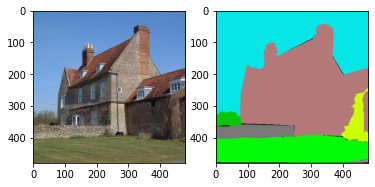

In [14]:
img, mask = val_dataset[0]
# get pallete for the mask
from gluoncv.utils.viz import get_color_pallete
mask = get_color_pallete(mask.asnumpy(), dataset='ade20k')
mask.save('mask.png')

# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img.asnumpy().astype('uint8'))
# subplot 2 for the mask
mmask = mpimg.imread('mask.png')
fig.add_subplot(1,2,2)
plt.imshow(mmask)
# display
plt.show()

# Model Architecture

## ZeroShotSegmentationNet architecture

In [88]:
class GaussianLaplacianLogic(gluon.nn.HybridBlock):
    def __init__(self, num_classes):
        super(GaussianLaplacianLogic, self).__init__()
        with self.name_scope():
            # Define layers for Gaussian parameters
            self.gaussian_mean = gluon.nn.Conv2D(num_classes, kernel_size=1)
            self.gaussian_variance = gluon.nn.Conv2D(num_classes, kernel_size=1, activation='softrelu')
            # softrelu activation is used to ensure the variance is positive

            # Define layers for Laplacian parameters
            self.laplacian_scale = gluon.nn.Conv2D(num_classes, kernel_size=1, activation='softrelu')

    def hybrid_forward(self, F, x):
        # Compute the Gaussian parameters
        mean = self.gaussian_mean(x)
        variance = self.gaussian_variance(x)

        # Compute the Laplacian scale parameter
        scale = self.laplacian_scale(x)

        # Combine Gaussian and Laplacian logic
        combined_output = F.broadcast_add(F.broadcast_div(mean, variance), scale)

        return combined_output
    
    
class ZeroShotSegmentationNet(gluon.nn.HybridBlock):
    def __init__(self, backbone, embedding_size, num_classes):
        super(ZeroShotSegmentationNet, self).__init__()
        with self.name_scope():
            self.backbone = backbone
            self.embedding_fc = gluon.nn.Dense(units=embedding_size)
            self.classifier = gluon.nn.Conv2D(num_classes, kernel_size=1)
            self.dice_layer = DiceLayer()
            self.custom_gaussian_laplacian_logic = GaussianLaplacianLogic(num_classes)


    def hybrid_forward(self, F, x, embedding):
        # Extract visual features from the image
        visual_features = self.backbone(x)

        # Process the semantic embeddings
        embedding_features = self.embedding_fc(embedding)
        # Resize embedding features to have the same spatial dimensions as visual features
        embedding_features = F.broadcast_to(embedding_features.expand_dims(-1).expand_dims(-1), visual_features.shape)

        # Combine visual and embedding features
        combined_features = F.broadcast_add(visual_features, embedding_features)

        # Apply classifier to combined features to get the segmentation logits
        logits = self.classifier(combined_features)

        # custom logic for Gaussian/Laplacian distribution
        logits = self.custom_gaussian_laplacian_logic(logits)

        # Apply DICE layer to logits to obtain the segmentation mask
        segmentation_mask = self.dice_layer(logits)

        return segmentation_mask


class DiceLayer(gluon.nn.HybridBlock):
    def __init__(self, smooth=1e-5, **kwargs):
        super(DiceLayer, self).__init__(**kwargs)
        self.smooth = smooth  # A small value to prevent division by zero

    def hybrid_forward(self, F, prediction, target):
        # Flatten the prediction and target tensors to compute the Dice coefficient
        prediction_flat = F.flatten(prediction)
        target_flat = F.flatten(target)

        # Compute the intersection and union
        intersection = F.sum(prediction_flat * target_flat)
        union = F.sum(prediction_flat) + F.sum(target_flat)
        
        # Compute the Dice coefficient
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score

        return dice_loss



# Define the backbone network (DeepLab with a ResNet-101 backbone)
backbone = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)
embedding_size = 300
num_classes = 150


# Instantiate the custom ZeroShotSegmentationNet
model = ZeroShotSegmentationNet(backbone=backbone, embedding_size=embedding_size, num_classes=num_classes)

# Initialize the parameters for the custom layers in the model
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu(0))

print(model)

ZeroShotSegmentationNet(
  (backbone): DeepLabV3(
    (conv1): HybridSequential(
      (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (2): Activation(relu)
      (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (5): Activation(relu)
      (6): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
    (relu): Activation(relu)
    (maxpool): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (layer1): HybridSequential(
      (0): BottleneckV1b(
        (conv1): Conv2D(128 ->

C:\Users\15148\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\parameter.py:862: UserWarning: Parameter 'deeplabv35_resnetv1s_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\Users\15148\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\parameter.py:862: UserWarning: Parameter 'deeplabv35_resnetv1s_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\Users\15148\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\parameter.py:862: UserWarning: Parameter 'deeplabv35_resnetv1s_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\Users\15148\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\parameter.py:862: UserWarning: Parameter 'deeplabv35_resnetv1s_batchnor

In [107]:
def label_to_index_mapping(dataset, predicted_label):
    """
    Get the index corresponding to the given label from the ADE20K dataset.

    Parameters:
    - dataset: The dataset object which contains the 'classes' attribute.
    - predicted_label: The label for which to find the index.

    Returns:
    - The index corresponding to the label, or -1 if not found.
    """
    # Create the mapping dictionary
    mapping = {label: idx for idx, label in enumerate(dataset.classes)}

    # Iterate over the mapping to find a match
    for label, idx in mapping.items():
        # Splitting the label in case it has multiple comma-separated values
        if predicted_label in label.split(', '):
            return idx

    # Return -1 or a default value if no match is found
    return -1

# Example usage
predicted_label = "traffic signal"
index = label_to_index_mapping(trainset, predicted_label)
print(index)  # Should print 136 if "traffic signal" is part of the label in the mapping


136


In [112]:
import mxnet as mx
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon import nn

def get_feature_extractor():
    """
    Loads a pre-trained model and modifies it to be used as a feature extractor.
    """
    # Load a pre-trained model, e.g., ResNet-50 pre-trained on ImageNet
    pretrained_net = models.resnet50_v2(pretrained=True)

    # Use all layers except the output layer as the feature extractor
    feature_extractor = nn.HybridSequential(prefix='')
    with feature_extractor.name_scope():
        for layer in pretrained_net.features:
            feature_extractor.add(layer)
    
    return feature_extractor

def img_transform(img, ctx, target_size=None):
    # Convert to float32
    img = img.astype('float32') / 255

    # Resize if a target size is provided
    if target_size is not None:
        img = mx.image.resize_short(img, min(target_size))
        img, _ = mx.image.center_crop(img, target_size)

    # Transpose from (H, W, C) to (C, H, W) if image has 3 dimensions
    if len(img.shape) == 3:
        img = mx.nd.transpose(img, (2, 0, 1))

    # Expand dimensions to add the batch axis
    img = img.expand_dims(axis=0)

    # Normalize
    mean = mx.nd.array([0.485, 0.456, 0.406], ctx=ctx).reshape((1, 3, 1, 1))
    std = mx.nd.array([0.229, 0.224, 0.225], ctx=ctx).reshape((1, 3, 1, 1))
    img = mx.image.color_normalize(img, mean=mean, std=std)

    return img.as_in_context(ctx)

def get_corresponding_embedding_for_img(img, embedding_layer, label_predictor):
    """
    Generate the corresponding embedding for an image.

    Parameters:
    - img: The input image for which to generate an embedding.
    - embedding_layer: The trained embedding layer that can map labels to embeddings.
    - label_predictor: A function or model that predicts the label index of the image.

    Returns:
    - An embedding for the predicted label of the image.
    """
    # Predict the label index of the image
    predicted_index = label_predictor(img)

    # Ensure predicted_index is an integer
    if isinstance(predicted_index, mx.nd.NDArray):
        predicted_index = predicted_index.asnumpy()[0]

    # Generate the embedding for the predicted label index
    embedding = embedding_layer(mx.nd.array([predicted_index]))

    return embedding

def embedding_generator(img, feature_extractor, embedding_layer, ctx=mx.cpu(0)):
    """
    Generates an embedding for a given image.

    Parameters:
    - img: The input image.
    - feature_extractor: A pre-trained model used as a feature extractor.
    - embedding_layer: A layer that maps features to embeddings.
    - ctx: The MXNet context to use.

    Returns:
    - An embedding for the image.
    """
    # Transform the image
    img = test_transform(img, ctx)
    img = mx.nd.expand_dims(img, axis=0)

    # Extract features
    features = feature_extractor(img)

    # Flatten the features
    flattened_features = features.reshape((1, -1))

    # Generate the embedding
    embedding = embedding_layer(flattened_features)
    
    return embedding

# Initialize the feature extractor and embedding layer
feature_extractor = get_feature_extractor()
embedding_layer = nn.Dense(300)  # Define the size of your embeddings
embedding_layer.initialize(mx.init.Xavier(), ctx=mx.cpu(0))



def predict_with_model(img, model, feature_extractor, embedding_layer, ctx=mx.cpu(0)):
    """
    Makes a prediction using the given model and feature extractor.

    Parameters:
    - img: The input image.
    - model: The ZeroShotSegmentationNet model.
    - feature_extractor: The pre-trained feature extractor.
    - embedding_layer: The embedding layer to generate embeddings.
    - ctx: The MXNet context.

    Returns:
    - The output of the model.
    """
    # Ensure the image is on the correct context
    img = img.as_in_context(ctx)

    # Check if the image is already in the batch format (B, C, H, W)
    if len(transformed_img.shape) != 4:
        # Expand dimensions to add batch dimension
        img = mx.nd.expand_dims(img, axis=0)


    # Extract features
    features = feature_extractor(img)

    # Flatten the features and generate the embedding
    flattened_features = features.reshape((1, -1))
    embedding = embedding_layer(flattened_features)

    # Forward pass through the model
    output = model(img, embedding)
    return output


In [113]:
img_tr = test_transform(img, mx.cpu(0))
                        
embedding = get_corresponding_embedding_for_img(img_tr, trainset.embedding_layer, model.classifier)
#embedding = nd.expand_dims(embedding, axis=0)

output = model((img_tr), embedding)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()


#Add color pallete for visualization
mask = get_color_pallete(predict, 'ade20k')
mask.save('results/output.png')


#show the predicted mask
mmask = mpimg.imread('results/output.png')
plt.imshow(mmask)
plt.show()

MXNetError: [22:22:02] C:\Jenkins\workspace\mxnet-tag\mxnet\src\operator\nn\concat.cc:67: Check failed: shape_assign(&(*in_shape)[i], dshape): Incompatible input shape: expected [1,-1,28,28], got [1,256,60,60]

# Creating the costum loss function

In [10]:
criterion = MixSoftmaxCrossEntropyLoss(aux=True)

lr_scheduler = gluoncv.utils.LRScheduler(mode='poly', base_lr=0.001,
                                         nepochs=50, iters_per_epoch=len(train_data), power=0.9)

print("Setting training to GPU")

ctx_list = [mx.gpu(0)] #[mx.cpu(0)]
#if net == None:
net = DataParallelModel(model, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

print("Creating the Optimizer")

#kv = mx.kv.create('local')
optimizer = gluon.Trainer(model.collect_params(), 'sgd',
                          {'lr_scheduler': lr_scheduler,
                           'wd':0.0001,
                           'momentum': 0.9,
                           'multi_precision': True})#,
                          #kvstore = kv)

Setting training to GPU
Creating the Optimizer


# Training

In [12]:
from tqdm import tqdm
import shutil

def save_checkpoint(net, args, epoch, mIoU, is_best=False):
    """Save Checkpoint"""
    save_dir = "models"
    filename = 'epoch_%04d_mIoU_%2.4f.params' % (epoch, mIoU)
    filepath = os.path.join(save_dir, filename)
    net.save_parameters(filepath)
    if is_best:
        shutil.copyfile(filename, os.path.join(save_dir, 'model_best.params'))
        
tbar = tqdm(train_data)
train_loss = 0.0
epoch = 10
    

  0%|                                                                                         | 0/2526 [01:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_loss = 0.0
steps = 500
try:
    for i, (data, target) in enumerate(train_data):
        with autograd.record(True):
            outputs = net(data) # model
            losses = criterion(outputs, target)
            mx.nd.waitall()
            autograd.backward(losses)
        optimizer.step(batch_size)
        for loss in losses:
            train_loss += loss.asnumpy()[0] / len(losses)
        print('Epoch %d, batch %d, training loss %.3f'%(epoch, i, train_loss/(i+1)))
        save_checkpoint(net.module, epoch, 0, True)
        # just demo for 2 iters
        if i > steps:
            save_checkpoint(net.module, epoch, 0, True)
except Exception as e:
    print(e)
    save_checkpoint(net.module, epoch, 0, True)
    

Epoch 10, batch 0, training loss 2.993
Epoch 10, batch 1, training loss 3.076
Epoch 10, batch 2, training loss 3.098
Epoch 10, batch 3, training loss 3.754
Epoch 10, batch 4, training loss 3.893
Epoch 10, batch 5, training loss 3.695
Epoch 10, batch 6, training loss 3.642
Epoch 10, batch 7, training loss 3.610
Epoch 10, batch 8, training loss 3.463
Epoch 10, batch 9, training loss 3.480
Epoch 10, batch 10, training loss 3.530
Epoch 10, batch 11, training loss 3.540
Epoch 10, batch 12, training loss 3.536
Epoch 10, batch 13, training loss 3.549
Epoch 10, batch 14, training loss 3.406
Epoch 10, batch 15, training loss 3.398
Epoch 10, batch 16, training loss 3.381
Epoch 10, batch 17, training loss 3.371
Epoch 10, batch 18, training loss 3.416
Epoch 10, batch 19, training loss 3.390
Epoch 10, batch 20, training loss 3.432
Epoch 10, batch 21, training loss 3.521
Epoch 10, batch 22, training loss 3.545
Epoch 10, batch 23, training loss 3.432
Epoch 10, batch 24, training loss 3.503
Epoch 10, 

In [ ]:
# 353 data base 4 credits
# ENGR 411 writing docs 
# 
# 

In [14]:
# Save model
save_checkpoint(net.module, 501, 0, True)

In [25]:

def predict_img(img, ctx_list):
    ctx = ctx_list[0]

    img, mask = val_dataset[0]

    img_test = test_transform(img, ctx)

    output = model.predict(img_test)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

    mask = get_color_pallete(predict, 'ade20k')
    
    return mask

# Process the first 5 images
for i in range(5):
    img, ground_truth = val_dataset[i]

    # Convert img to batched format
    batched_img = img.expand_dims(axis=0)

    # Get the predicted mask
    predicted_mask = predict_img(batched_img, ctx_list)
    predicted_mask.save(f'results/predicted_mask_{i}.png')
    predicted_mask_img = mpimg.imread(f'results/predicted_mask_{i}.png')
    
    # Get palette for the original mask
    original_mask = get_color_pallete(ground_truth.asnumpy(), dataset='ade20k')
    original_mask.save(f'results/original_mask_{i}.png')
    
    original_mask_img = mpimg.imread(f'results/original_mask_{i}.png')

    # Create subplot for each image and its mask
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Subplot for the original image
    ax[0].imshow(img.asnumpy().astype('uint8'))
    ax[0].set_title(f"Original Image {i+1}")
    ax[0].axis('off')

    # Subplot for the predicted mask
    ax[1].imshow(predicted_mask_img)
    ax[1].set_title(f"Predicted Mask {i+1}")
    ax[1].axis('off')

    # Subplot for the predicted mask
    ax[2].imshow(original_mask_img)
    ax[2].set_title(f"Ground Truth {i+1}")
    ax[2].axis('off')

    
    # Display the plots
    plt.show()

TypeError: 'Context' object does not support indexing

# Visualization and Evaluation

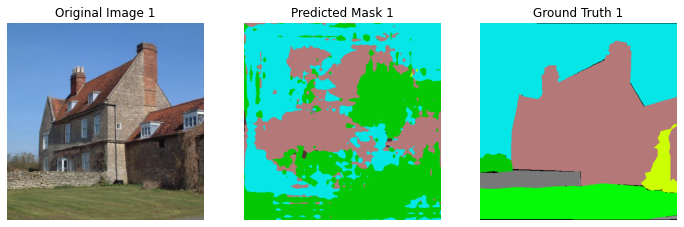

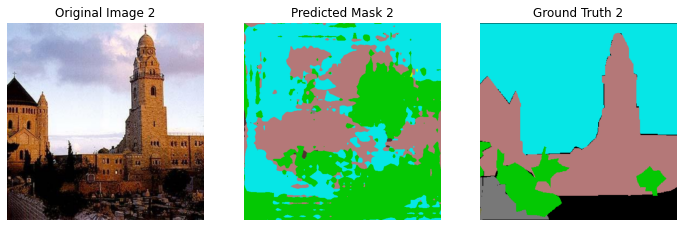

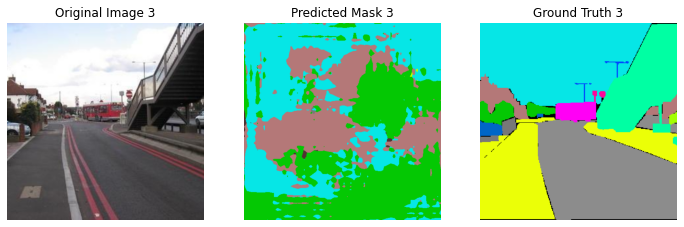

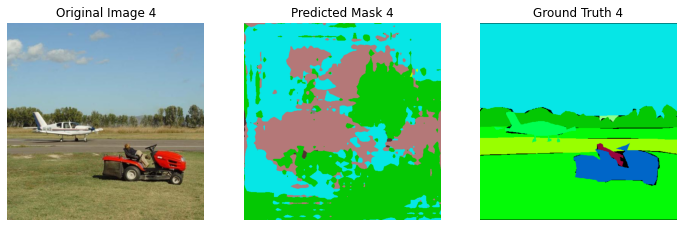

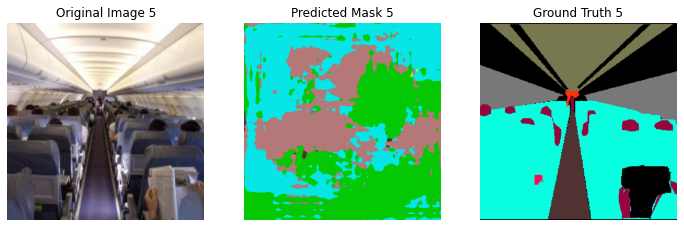

In [14]:
from gluoncv.data.transforms.presets.segmentation import test_transform

def predict_img(img, ctx_list):
    ctx = ctx_list[0]

    img, mask = val_dataset[0]

    img_test = test_transform(img, ctx)

    output = model.predict(img_test)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

    mask = get_color_pallete(predict, 'ade20k')
    
    return mask

# Process the first 5 images
for i in range(5):
    img, ground_truth = val_dataset[i]

    # Convert img to batched format
    batched_img = img.expand_dims(axis=0)

    # Get the predicted mask
    predicted_mask = predict_img(batched_img, ctx_list)
    predicted_mask.save(f'results/predicted_mask_{i}.png')
    predicted_mask_img = mpimg.imread(f'results/predicted_mask_{i}.png')
    
    # Get palette for the original mask
    original_mask = get_color_pallete(ground_truth.asnumpy(), dataset='ade20k')
    original_mask.save(f'results/original_mask_{i}.png')
    
    original_mask_img = mpimg.imread(f'results/original_mask_{i}.png')

    # Create subplot for each image and its mask
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Subplot for the original image
    ax[0].imshow(img.asnumpy().astype('uint8'))
    ax[0].set_title(f"Original Image {i+1}")
    ax[0].axis('off')

    # Subplot for the predicted mask
    ax[1].imshow(predicted_mask_img)
    ax[1].set_title(f"Predicted Mask {i+1}")
    ax[1].axis('off')

    # Subplot for the predicted mask
    ax[2].imshow(original_mask_img)
    ax[2].set_title(f"Ground Truth {i+1}")
    ax[2].axis('off')

    
    # Display the plots
    plt.show()